Importing libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.model_selection import train_test_split

Setting options and random seed for reproducibility

In [2]:
pd.set_option("display.max_columns", None)
np.random.seed(42)

Creating simple sample data frame to practise different imputation techniques

In [4]:
# Możliwe kategorie zmiennych jakościowych
cities = ["Warszawa", "Kraków", "Wrocław", "Gdańsk"]
eye_colors = ["niebieskie", "zielone", "brązowe"]
education_levels = ["podstawowe", "średnie", "wyższe", "podyplomowe"]

# Tworzymy DataFrame
df = pd.DataFrame({
    "wiek": np.random.randint(18, 65, 20),  # dyskretna
    "wzrost_cm": np.random.normal(170, 10, 20).round(1),  # ciągła
    "dochód_mies": np.random.normal(5000, 1500, 20).round(0),  # ciągła
    "liczba_dzieci": np.random.randint(0, 4, 20),  # dyskretna
    "liczba_pokoi": np.random.randint(1, 6, 20),  # dyskretna
    "miasto": np.random.choice(cities, 20),  # nominalna
    "kolor_oczu": np.random.choice(eye_colors, 20),  # nominalna
    "wykształcenie": pd.Categorical(
        np.random.choice(education_levels, 20),
        categories=education_levels,
        ordered=True
    ),  # porządkowa
    "ocena_usługi": np.random.randint(1, 6, 20),  # porządkowa (1–5)
    "czas_spędzony_online_h": np.random.exponential(scale=2, size=20).round(1)  # ciągła
})

# Wprowadzamy trochę braków danych losowo (~15%)
for col in df.columns:
    df.loc[df.sample(frac=0.15, random_state=np.random.randint(100)).index, col] = np.nan

df.head(10)

,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
0,46.0,161.6,2225.0,3.0,1.0,Gdańsk,zielone,podyplomowe,2.0,2.0
1,NaN,176.8,6753.0,NaN,4.0,NaN,zielone,podstawowe,NaN,2.6
2,37.0,188.7,3522.0,2.0,4.0,NaN,niebieskie,podyplomowe,2.0,7.4
3,53.0,NaN,3359.0,1.0,5.0,Kraków,niebieskie,podyplomowe,2.0,1.5
4,36.0,163.7,681.0,NaN,5.0,Wrocław,niebieskie,średnie,NaN,0.8
5,43.0,164.8,3795.0,1.0,3.0,Kraków,brązowe,NaN,4.0,3.2
6,20.0,170.1,4993.0,0.0,NaN,Kraków,zielone,średnie,2.0,0.6
7,36.0,173.8,4425.0,3.0,NaN,Wrocław,NaN,podyplomowe,3.0,1.2
8,37.0,170.6,4306.0,2.0,5.0,Gdańsk,niebieskie,NaN,4.0,0.2
9,49.0,175.0,3331.0,3.0,5.0,Kraków,zielone,wyższe,5.0,0.1


In [82]:
df.dtypes

wiek                       float64
wzrost_cm                  float64
dochód_mies                float64
liczba_dzieci              float64
liczba_pokoi               float64
miasto                      object
kolor_oczu                  object
wykształcenie             category
ocena_usługi               float64
czas_spędzony_online_h     float64
dtype: object

In [7]:
print('Kategorie zmiennej "wykształcenie": ',df["wykształcenie"].cat.categories)
df["wykształcenie"].cat.codes.value_counts()

Kategorie zmiennej "wykształcenie":  Index(['podstawowe', 'średnie', 'wyższe', 'podyplomowe'], dtype='object')


 3    5
 1    5
 2    5
-1    3
 0    2
Name: count, dtype: int64

In [6]:
# checking the percentage of missing values in each variable -> we made it 15%
df.isna().mean()

wiek                      0.15
wzrost_cm                 0.15
dochód_mies               0.15
liczba_dzieci             0.15
liczba_pokoi              0.15
miasto                    0.15
kolor_oczu                0.15
wykształcenie             0.15
ocena_usługi              0.15
czas_spędzony_online_h    0.15
dtype: float64

In [8]:
# categorical variables
cat_cols = [col for col in df.columns if df[col].dtype == "O" or df[col].dtype == "category"]
num_cols = [col for col in df.columns if col not in cat_cols]
print("Categorical variables:", cat_cols)
print("Numerical variables:", num_cols)

Categorical variables: ['miasto', 'kolor_oczu', 'wykształcenie']
Numerical variables: ['wiek', 'wzrost_cm', 'dochód_mies', 'liczba_dzieci', 'liczba_pokoi', 'ocena_usługi', 'czas_spędzony_online_h']


**Usually here we split our data into train and test set before we learn the values to impute.** I will skip this part intentionally.

Computing means, medians, modes, checking the sample distributions...

{'wiek': 41.0, 'wzrost_cm': 168.0, 'dochód_mies': 5682.0, 'liczba_dzieci': 1.0, 'liczba_pokoi': 3.0, 'ocena_usługi': 3.0, 'czas_spędzony_online_h': 2.0}
{'wiek': 40.0, 'wzrost_cm': 168.8, 'dochód_mies': 5691.0, 'liczba_dzieci': 2.0, 'liczba_pokoi': 3.0, 'ocena_usługi': 3.0, 'czas_spędzony_online_h': 0.9}


array([[<Axes: title={'center': 'wiek'}>,
        <Axes: title={'center': 'wzrost_cm'}>,
        <Axes: title={'center': 'dochód_mies'}>],
       [<Axes: title={'center': 'liczba_dzieci'}>,
        <Axes: title={'center': 'liczba_pokoi'}>,
        <Axes: title={'center': 'ocena_usługi'}>],
       [<Axes: title={'center': 'czas_spędzony_online_h'}>, <Axes: >,
        <Axes: >]], dtype=object)

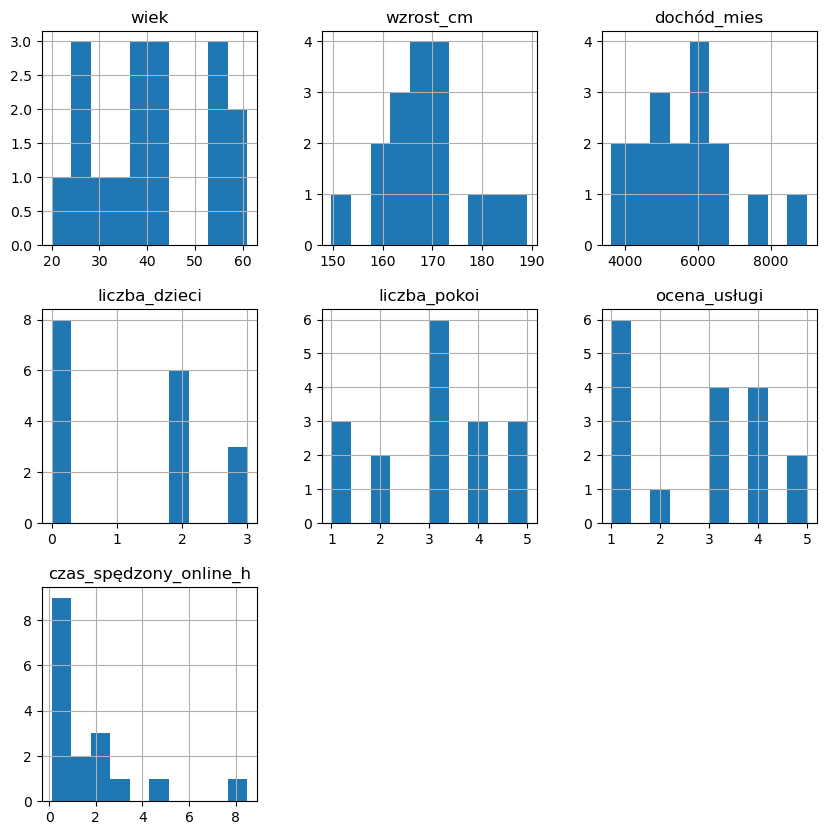

In [87]:
# creating a dictionary with the num variables means
mean_dict = df[num_cols].mean().round().to_dict()
# creating a dictionary with the num variables medians
median_dict = df[num_cols].median().to_dict()
print(mean_dict)
print(median_dict)

df[num_cols].hist(figsize=(10,10))

In [88]:
# creating a dictionary with the cat variables modes
mode_dict = df[cat_cols].mode().iloc[0,:].to_dict() # -> gdyby była więcej niż jedna modalna
mode_dict

{'miasto': 'Wrocław',
 'kolor_oczu': 'niebieskie',
 'wykształcenie': 'podyplomowe'}

## Basic imputation methods with `pandas`

In [89]:
df_p = df.copy()

df_p.fillna(mode_dict, inplace=True)
df_p.isna().sum()

df_p_mean = df_p.fillna(mean_dict)
df_p_mean.isna().sum()

df_p_median = df_p.fillna(median_dict)
df_p_median.isna().sum()

wiek                      0
wzrost_cm                 0
dochód_mies               0
liczba_dzieci             0
liczba_pokoi              0
miasto                    0
kolor_oczu                0
wykształcenie             0
ocena_usługi              0
czas_spędzony_online_h    0
dtype: int64

Let's check some variables and how their sample distributions has changed after different imputation methods.

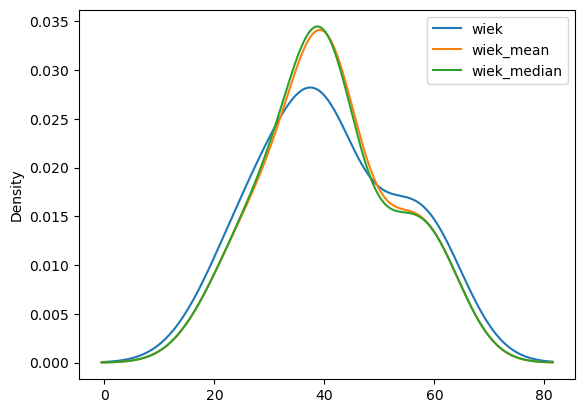

In [90]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
df_p["wiek"].plot(kind="kde", label="wiek")
df_p_mean["wiek"].plot(kind="kde", label="wiek_mean")
df_p_median["wiek"].plot(kind="kde", label="wiek_median")

ax.legend()
plt.show()

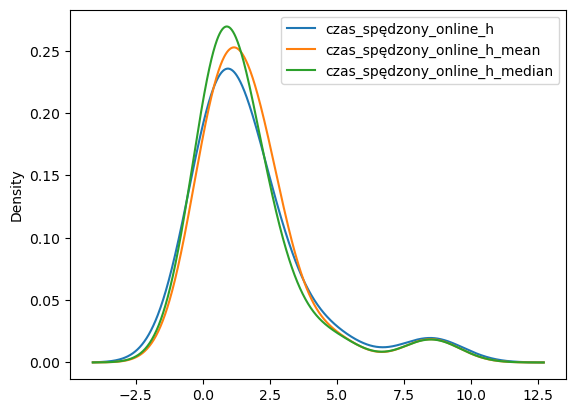

In [91]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
df_p["czas_spędzony_online_h"].plot(kind="kde", label="czas_spędzony_online_h")
df_p_mean["czas_spędzony_online_h"].plot(kind="kde", label="czas_spędzony_online_h_mean")
df_p_median["czas_spędzony_online_h"].plot(kind="kde", label="czas_spędzony_online_h_median")

ax.legend()
plt.show()

<Axes: >

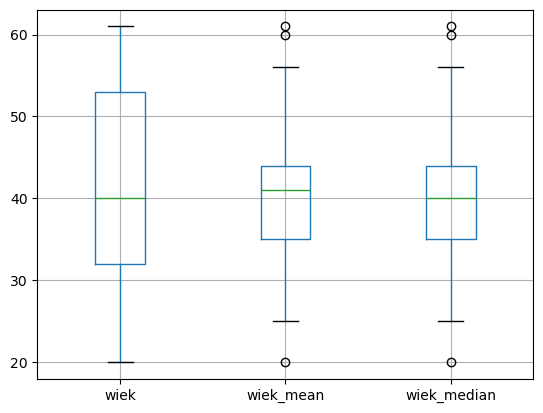

In [92]:
df_wiek = pd.concat([df_p["wiek"], df_p_mean["wiek"], df_p_median["wiek"]], axis=1)
df_wiek.columns = ["wiek", "wiek_mean", "wiek_median"]
df_wiek.boxplot()

After imputation we atrificially created three outliers.

We can create one dictionary with both numerical and categorical variables that we want to impute in a one-liner

In [93]:
dict = mean_dict.copy()
dict.update(mode_dict)
dict

df_1 = df.copy()
df_1.fillna(dict, inplace=True)
df_1.isna().sum()

wiek                      0
wzrost_cm                 0
dochód_mies               0
liczba_dzieci             0
liczba_pokoi              0
miasto                    0
kolor_oczu                0
wykształcenie             0
ocena_usługi              0
czas_spędzony_online_h    0
dtype: int64

We can also use some arbitrary numbers and values in a dictionary, for example:

In [94]:
arbitraty_dict = {
    "wiek": -1,
    "miasto": "missing"
}

Creating missing indicators in df using `pandas`

In [95]:
# create a new copy of df
df_p = df.copy()

# df_p.isna().astype(int) -> data frame with 0s and 1s
# we can use the above to create missing indicators and concatenate them with the original df

# first we need to create a list of names for missing indicator columns as pandas does not create the names with prefixes nor sufixes
name = "Asia"
f"{name}" + "Asia"

indicators = [f"{col}_na" for col in df_p.columns] # używamy f-strings i dodajemy "_na" do nazwy każdej kolumny
# [str(col)+"_na" for col in df_p.columns] też działa
print(indicators)

# teraz dodajemy nowe kolumny w instniejącej df df_p
df_p[indicators] = df_p.isna().astype(int)
df_p

['wiek_na', 'wzrost_cm_na', 'dochód_mies_na', 'liczba_dzieci_na', 'liczba_pokoi_na', 'miasto_na', 'kolor_oczu_na', 'wykształcenie_na', 'ocena_usługi_na', 'czas_spędzony_online_h_na']


,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h,wiek_na,wzrost_cm_na,dochód_mies_na,liczba_dzieci_na,liczba_pokoi_na,miasto_na,kolor_oczu_na,wykształcenie_na,ocena_usługi_na,czas_spędzony_online_h_na
0,56.0,170.2,5849.0,0.0,3.0,NaN,niebieskie,średnie,1.0,NaN,0,0,0,0,0,1,0,0,0,1
1,NaN,165.7,3943.0,2.0,5.0,Kraków,zielone,podyplomowe,4.0,1.4,1,0,0,0,0,0,0,0,0,0
2,32.0,164.7,NaN,0.0,2.0,Wrocław,niebieskie,podyplomowe,5.0,0.7,0,0,1,0,0,0,0,0,0,0
3,60.0,168.8,4470.0,0.0,NaN,NaN,NaN,podyplomowe,1.0,0.7,0,0,0,0,1,1,1,0,0,0
4,25.0,172.2,4308.0,0.0,1.0,Kraków,brązowe,podyplomowe,3.0,0.1,0,0,0,0,0,0,0,0,0,0
5,38.0,162.3,5100.0,NaN,4.0,Wrocław,niebieskie,podyplomowe,3.0,1.9,0,0,0,1,0,0,0,0,0,0
6,56.0,171.4,4736.0,0.0,1.0,Wrocław,NaN,średnie,1.0,NaN,0,0,0,0,0,0,1,0,0,1
7,36.0,169.7,6801.0,NaN,4.0,Warszawa,brązowe,średnie,5.0,0.1,0,0,0,1,0,0,0,0,0,0
8,40.0,181.3,6048.0,0.0,2.0,NaN,niebieskie,wyższe,1.0,0.7,0,0,0,0,0,1,0,0,0,0
9,28.0,169.0,NaN,3.0,1.0,Wrocław,niebieskie,podyplomowe,3.0,4.8,0,0,1,0,0,0,0,0,0,0


## Basic imputation methods with `sklearn`

In [96]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [97]:
df_s = df.copy()
#df_s[num_cols]
#df_s[cat_cols]

`SimpleImputer` will impute all the variables in a df using the same strategy. When using 'mean'/'median' on categoriacal variables, will throw an error.

`SimpleImputer` returning a NumPy array by default

In [98]:
imputer = SimpleImputer(strategy="median")

#imputer.fit(df_s) throws a ValueError
imputer.fit(df_s[num_cols])

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [99]:
# every learned parameter or atribute can be reached using _ after the name
imputer.statistics_

array([4.000e+01, 1.688e+02, 5.691e+03, 2.000e+00, 3.000e+00, 3.000e+00,
       9.000e-01])

In [100]:
# we can check if those learned parameters are correct using pandas .median() method
df_s[num_cols].median()

wiek                        40.0
wzrost_cm                  168.8
dochód_mies               5691.0
liczba_dzieci                2.0
liczba_pokoi                 3.0
ocena_usługi                 3.0
czas_spędzony_online_h       0.9
dtype: float64

In [101]:
df_s[num_cols] = imputer.transform(df_s[num_cols]) # returns a NumPy array by default oops
df_s

,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
0,56.0,170.2,5849.0,0.0,3.0,NaN,niebieskie,średnie,1.0,0.9
1,40.0,165.7,3943.0,2.0,5.0,Kraków,zielone,podyplomowe,4.0,1.4
2,32.0,164.7,5691.0,0.0,2.0,Wrocław,niebieskie,podyplomowe,5.0,0.7
3,60.0,168.8,4470.0,0.0,3.0,NaN,NaN,podyplomowe,1.0,0.7
4,25.0,172.2,4308.0,0.0,1.0,Kraków,brązowe,podyplomowe,3.0,0.1
5,38.0,162.3,5100.0,2.0,4.0,Wrocław,niebieskie,podyplomowe,3.0,1.9
6,56.0,171.4,4736.0,0.0,1.0,Wrocław,NaN,średnie,1.0,0.9
7,36.0,169.7,6801.0,2.0,4.0,Warszawa,brązowe,średnie,5.0,0.1
8,40.0,181.3,6048.0,0.0,2.0,NaN,niebieskie,wyższe,1.0,0.7
9,28.0,169.0,5691.0,3.0,1.0,Wrocław,niebieskie,podyplomowe,3.0,4.8


In [102]:
# możemy wyciągnąć nazwy kolumn, ponieważ domyślnie `SimpleImputer`zwraca NumPy array, czyli nie ma nazw kolumn
# kiedyś trzeba było to ręcznie przerobić na df
print("Columns from dataframe in a NumPy array:", imputer.get_feature_names_out())
#imputed_df_s = pd.DataFrame(df_s[num_cols], columns=imputer.get_feature_names_out())

Columns from dataframe in a NumPy array: ['wiek' 'wzrost_cm' 'dochód_mies' 'liczba_dzieci' 'liczba_pokoi'
 'ocena_usługi' 'czas_spędzony_online_h']


`SimpleImputer` returning a DataFrame

In [103]:
imputer = SimpleImputer(strategy="median").set_output(transform="pandas")
# and the rest procedure is the same

`ColumnTransformer`

In [104]:
ct = ColumnTransformer(
    transformers=[("num_imputer", SimpleImputer(strategy="median"), num_cols),
                  ("cat_imputer", SimpleImputer(strategy="most_frequent"), cat_cols)],
    remainder="passthrough"
)

ct.set_output(transform="pandas")

,transformers,"[('num_imputer', ...), ('cat_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [105]:
df_s = df.copy()

ct.fit(df_s)

,transformers,"[('num_imputer', ...), ('cat_imputer', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [106]:
# we can see all of the transformers
ct.transformers_

[('num_imputer',
  SimpleImputer(strategy='median'),
  ['wiek',
   'wzrost_cm',
   'dochód_mies',
   'liczba_dzieci',
   'liczba_pokoi',
   'ocena_usługi',
   'czas_spędzony_online_h']),
 ('cat_imputer',
  SimpleImputer(strategy='most_frequent'),
  ['miasto', 'kolor_oczu', 'wykształcenie'])]

In [107]:
# and when we choose one of the transformers from the list above using its name, we can access the statistics
ct.named_transformers_ # to jest słownik
ct.named_transformers_["num_imputer"].statistics_

array([4.000e+01, 1.688e+02, 5.691e+03, 2.000e+00, 3.000e+00, 3.000e+00,
       9.000e-01])

**But the `ColumnTransformer` changes the variables names adding at the beginning "imputers_name_"**.

**And the other variables that weren't imputated now have "remainder_" added at the beginning**

In [108]:
df_s = ct.transform(df_s)
df_s

,num_imputer__wiek,num_imputer__wzrost_cm,num_imputer__dochód_mies,num_imputer__liczba_dzieci,num_imputer__liczba_pokoi,num_imputer__ocena_usługi,num_imputer__czas_spędzony_online_h,cat_imputer__miasto,cat_imputer__kolor_oczu,cat_imputer__wykształcenie
0,56.0,170.2,5849.0,0.0,3.0,1.0,0.9,Wrocław,niebieskie,średnie
1,40.0,165.7,3943.0,2.0,5.0,4.0,1.4,Kraków,zielone,podyplomowe
2,32.0,164.7,5691.0,0.0,2.0,5.0,0.7,Wrocław,niebieskie,podyplomowe
3,60.0,168.8,4470.0,0.0,3.0,1.0,0.7,Wrocław,niebieskie,podyplomowe
4,25.0,172.2,4308.0,0.0,1.0,3.0,0.1,Kraków,brązowe,podyplomowe
5,38.0,162.3,5100.0,2.0,4.0,3.0,1.9,Wrocław,niebieskie,podyplomowe
6,56.0,171.4,4736.0,0.0,1.0,1.0,0.9,Wrocław,niebieskie,średnie
7,36.0,169.7,6801.0,2.0,4.0,5.0,0.1,Warszawa,brązowe,średnie
8,40.0,181.3,6048.0,0.0,2.0,1.0,0.7,Wrocław,niebieskie,wyższe
9,28.0,169.0,5691.0,3.0,1.0,3.0,4.8,Wrocław,niebieskie,podyplomowe


In [109]:
# checking na
# and the variable names
df_s.isna().sum()

num_imputer__wiek                      0
num_imputer__wzrost_cm                 0
num_imputer__dochód_mies               0
num_imputer__liczba_dzieci             0
num_imputer__liczba_pokoi              0
num_imputer__ocena_usługi              0
num_imputer__czas_spędzony_online_h    0
cat_imputer__miasto                    0
cat_imputer__kolor_oczu                0
cat_imputer__wykształcenie             0
dtype: int64

**Note**: The variables in a returned DataFrame will be in a different order than in the original DataFrame!! The imputed variables will be the first ones and then there will be the variables that weren't imputed with the "remainder_" prefix.

In the example above the order is the same, because we imputed all of the variables.

**And that's because...**

The ColumnTransformer is, in essence, just slicing the dataframe into the required feature subsets. The SimpleImputer then performs operations on the sliced dataframes. Finally, the dataframes are put back together for the final output.

That means that the order of the columns is not the same as in the training set!

#### Ok, sprawdzę to, co wyżej napisałam, tylko wybiorę po jednej zmiennej numerycznej ("dochód") i kategorialnej ("wykształcenie"), tak żeby nie były to pierwsze zmienne z df.

In [110]:
ct_new = ColumnTransformer(
    transformers=[
        ("mean_imp", SimpleImputer(strategy="mean"), ["dochód_mies"]),
        ("mode_imp", SimpleImputer(strategy="most_frequent"), ["wykształcenie"])
    ],
    remainder="passthrough"
)
ct_new.set_output(transform="pandas")

df_s = df.copy()

ct_new.fit(df_s)
df_s = ct_new.transform(df_s)
df_s

,mean_imp__dochód_mies,mode_imp__wykształcenie,remainder__wiek,remainder__wzrost_cm,remainder__liczba_dzieci,remainder__liczba_pokoi,remainder__miasto,remainder__kolor_oczu,remainder__ocena_usługi,remainder__czas_spędzony_online_h
0,5849.000000,średnie,56.0,170.2,0.0,3.0,NaN,niebieskie,1.0,NaN
1,3943.000000,podyplomowe,NaN,165.7,2.0,5.0,Kraków,zielone,4.0,1.4
2,5682.294118,podyplomowe,32.0,164.7,0.0,2.0,Wrocław,niebieskie,5.0,0.7
3,4470.000000,podyplomowe,60.0,168.8,0.0,NaN,NaN,NaN,1.0,0.7
4,4308.000000,podyplomowe,25.0,172.2,0.0,1.0,Kraków,brązowe,3.0,0.1
5,5100.000000,podyplomowe,38.0,162.3,NaN,4.0,Wrocław,niebieskie,3.0,1.9
6,4736.000000,średnie,56.0,171.4,0.0,1.0,Wrocław,NaN,1.0,NaN
7,6801.000000,średnie,36.0,169.7,NaN,4.0,Warszawa,brązowe,5.0,0.1
8,6048.000000,wyższe,40.0,181.3,0.0,2.0,NaN,niebieskie,1.0,0.7
9,5682.294118,podyplomowe,28.0,169.0,3.0,1.0,Wrocław,niebieskie,3.0,4.8


No i rzeczywiście jest tak jak wyżej napisałam.

### To teraz przykład **arbitrary value imputation** z `SimpleImputer`

In [111]:
# przypomnienie: 
# ten imputer KAŻDY NA z df zastąpi stringiem "missing" i wtedy zmienne numeryczne będą miały dtype="O"
imputer = SimpleImputer(
    strategy="constant",
    fill_value="missing"
)

imputer.set_output(transform="pandas")

,missing_values,nan
,strategy,'constant'
,fill_value,'missing'
,copy,True
,add_indicator,False
,keep_empty_features,False


### RESZTA KODU TAK SAMO
z tym że teraz imputer nie uczy się parametrów, ale i tak używamy metody fit

### Missing indicators in `sklearn`

#### Jak działa parametr `add_indicator=True` z `SimpleImputer`??

In [112]:
ct_new = ColumnTransformer(
    transformers=[
        ("mean_imp", SimpleImputer(strategy="mean", add_indicator=True), ["dochód_mies"]),
        ("mode_imp", SimpleImputer(strategy="most_frequent", add_indicator=True), ["wykształcenie"])
    ],
    remainder="drop" # w rezultacie otrzymamy tylko zmienne "dochód_mies" i "wykształcenie" i dwie kolumny z missing indicators
)
ct_new.set_output(transform="pandas")

df_s = df.copy()

ct_new.fit(df_s)
df_s = ct_new.transform(df_s)
df_s

,mean_imp__dochód_mies,mean_imp__missingindicator_dochód_mies,mode_imp__wykształcenie,mode_imp__missingindicator_wykształcenie
0,5849.000000,0.0,średnie,False
1,3943.000000,0.0,podyplomowe,False
2,5682.294118,1.0,podyplomowe,False
3,4470.000000,0.0,podyplomowe,False
4,4308.000000,0.0,podyplomowe,False
5,5100.000000,0.0,podyplomowe,False
6,4736.000000,0.0,średnie,False
7,6801.000000,0.0,średnie,False
8,6048.000000,0.0,wyższe,False
9,5682.294118,1.0,podyplomowe,False


**Note**:
Kolejność kolumn:
- imputowana kolumna z pierwszego transformera
- missing indicator
- imputowana kolumna z drugiego transformera
- missing indicator

#### Nowa klasa `MissingIndicator`

In [113]:
from sklearn.impute import MissingIndicator

In [114]:
indicator = MissingIndicator(
    features="missing-only",
    error_on_new=True # explanation in the cell below
)

parametr `error_on_new` kontroluje zachowanie wskaźnika braków danych w trakcie predykcji (`transform`) w sytuacji, gdy w nowych danych pojawią się braki (`NaN`) w kolumnach, które nie miały braków w danych uczących (`fit`)

In [115]:
# 4 kolumny tylko, żeby były widać lepiej i wygodniej
subset = df[["wiek", "dochód_mies", "miasto", "wykształcenie"]]

indicator.fit(subset)

,missing_values,nan
,features,'missing-only'
,sparse,'auto'
,error_on_new,True


In [116]:
# zwróci indeksy z df, którą podaliśmy do fit, indeksy, które mają braki, bo podczas instantiate podaliśmy features="missing-only"
indicator.features_

array([0, 1, 2, 3], dtype=int64)

In [117]:
# teraz możemy zobaczyć, które kolumny z df miały braki, używając powyższych indeksów
subset.columns[indicator.features_]

Index(['wiek', 'dochód_mies', 'miasto', 'wykształcenie'], dtype='object')

In [118]:
# sztuczka xd mogę sobie wybrać kolumny z wyjściowej df używając indeksów z indicatora
df[df.columns[indicator.features_]]

,wiek,wzrost_cm,dochód_mies,liczba_dzieci
0,56.0,170.2,5849.0,0.0
1,NaN,165.7,3943.0,2.0
2,32.0,164.7,NaN,0.0
3,60.0,168.8,4470.0,0.0
4,25.0,172.2,4308.0,0.0
5,38.0,162.3,5100.0,NaN
6,56.0,171.4,4736.0,0.0
7,36.0,169.7,6801.0,NaN
8,40.0,181.3,6048.0,0.0
9,28.0,169.0,NaN,3.0


In [119]:
tmp = indicator.transform(subset) # tmp od temporary
tmp # a NumPy array

array([[False, False,  True, False],
       [ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False,  True, False],
       [False,  True, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True],
       [ True, False, False,  True],
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False,  True],
       [ True, False, False, False],
       [False,  True, False, False],
       [False, False, False, False]])

In [120]:
tmp_df = pd.DataFrame(tmp, columns=subset.columns[indicator.features_]).astype(int)
tmp_df

,wiek,dochód_mies,miasto,wykształcenie
0,0,0,1,0
1,1,0,0,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,0,1,0
9,0,1,0,0


In [121]:
# concatenate two dfs, subset and temp_df which is a df with missing indicators of subset variables
subset_mi = pd.concat([subset, tmp_df], axis=1)
# w kursie babeczka ustawiła jeszcze subset.reset_index(), bo ona miała X_train, czyli randomowe wiersze z X, które zachowały swoje indeksy
subset_mi

,wiek,dochód_mies,miasto,wykształcenie,wiek,dochód_mies,miasto,wykształcenie
0,56.0,5849.0,NaN,średnie,0,0,1,0
1,NaN,3943.0,Kraków,podyplomowe,1,0,0,0
2,32.0,NaN,Wrocław,podyplomowe,0,1,0,0
3,60.0,4470.0,NaN,podyplomowe,0,0,1,0
4,25.0,4308.0,Kraków,podyplomowe,0,0,0,0
5,38.0,5100.0,Wrocław,podyplomowe,0,0,0,0
6,56.0,4736.0,Wrocław,średnie,0,0,0,0
7,36.0,6801.0,Warszawa,średnie,0,0,0,0
8,40.0,6048.0,NaN,wyższe,0,0,1,0
9,28.0,NaN,Wrocław,podyplomowe,0,1,0,0


In [122]:
# bo indeksy pozostają te oryginalne jak robimy subset
mini = df.iloc[12:15]
mini

,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
12,53.0,149.7,6178.0,2.0,4.0,Gdańsk,NaN,NaN,3.0,1.3
13,NaN,181.2,8984.0,2.0,3.0,Warszawa,zielone,NaN,1.0,8.5
14,41.0,NaN,5395.0,2.0,3.0,Wrocław,zielone,wyższe,NaN,NaN


## CCA - Complete Case Analysis

### CCA in `pandas`

In [123]:
# wczytajmy znowu df z pierwszej komórki
df

,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
0,56.0,170.2,5849.0,0.0,3.0,NaN,niebieskie,średnie,1.0,NaN
1,NaN,165.7,3943.0,2.0,5.0,Kraków,zielone,podyplomowe,4.0,1.4
2,32.0,164.7,NaN,0.0,2.0,Wrocław,niebieskie,podyplomowe,5.0,0.7
3,60.0,168.8,4470.0,0.0,NaN,NaN,NaN,podyplomowe,1.0,0.7
4,25.0,172.2,4308.0,0.0,1.0,Kraków,brązowe,podyplomowe,3.0,0.1
5,38.0,162.3,5100.0,NaN,4.0,Wrocław,niebieskie,podyplomowe,3.0,1.9
6,56.0,171.4,4736.0,0.0,1.0,Wrocław,NaN,średnie,1.0,NaN
7,36.0,169.7,6801.0,NaN,4.0,Warszawa,brązowe,średnie,5.0,0.1
8,40.0,181.3,6048.0,0.0,2.0,NaN,niebieskie,wyższe,1.0,0.7
9,28.0,169.0,NaN,3.0,1.0,Wrocław,niebieskie,podyplomowe,3.0,4.8


In [124]:
# gdyby usunąć wszystkie obserwacje, które mają chociaż jeden nan, to z 20 zostaną 2 obserwacje
df.dropna()

,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
4,25.0,172.2,4308.0,0.0,1.0,Kraków,brązowe,podyplomowe,3.0,0.1
11,41.0,189.1,6783.0,3.0,3.0,Kraków,brązowe,wyższe,4.0,0.3


In [125]:
# axis=1 patrzy na kolumny, w tym wypadku mamy pusty df, bo każda kolumna ma dokładnie 3 na
#df.dropna(axis=1)

In [126]:
# wyrzucamy te obserwacje, które mają co najmniej 1 nan w którejś z trzech poniższych kolumn, plus dajemy nowe indeksy
df.dropna(subset=["wiek", "liczba_pokoi", "ocena_usługi"], ignore_index=True)

,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
0,56.0,170.2,5849.0,0.0,3.0,NaN,niebieskie,średnie,1.0,NaN
1,32.0,164.7,NaN,0.0,2.0,Wrocław,niebieskie,podyplomowe,5.0,0.7
2,25.0,172.2,4308.0,0.0,1.0,Kraków,brązowe,podyplomowe,3.0,0.1
3,38.0,162.3,5100.0,NaN,4.0,Wrocław,niebieskie,podyplomowe,3.0,1.9
4,56.0,171.4,4736.0,0.0,1.0,Wrocław,NaN,średnie,1.0,NaN
5,36.0,169.7,6801.0,NaN,4.0,Warszawa,brązowe,średnie,5.0,0.1
6,40.0,181.3,6048.0,0.0,2.0,NaN,niebieskie,wyższe,1.0,0.7
7,28.0,169.0,NaN,3.0,1.0,Wrocław,niebieskie,podyplomowe,3.0,4.8
8,28.0,164.7,3639.0,NaN,5.0,Kraków,brązowe,średnie,2.0,0.5
9,41.0,189.1,6783.0,3.0,3.0,Kraków,brązowe,wyższe,4.0,0.3


In [127]:
df.dropna(thresh=df.shape[1]-1, ignore_index=True)

,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
0,NaN,165.7,3943.0,2.0,5.0,Kraków,zielone,podyplomowe,4.0,1.4
1,32.0,164.7,NaN,0.0,2.0,Wrocław,niebieskie,podyplomowe,5.0,0.7
2,25.0,172.2,4308.0,0.0,1.0,Kraków,brązowe,podyplomowe,3.0,0.1
3,38.0,162.3,5100.0,NaN,4.0,Wrocław,niebieskie,podyplomowe,3.0,1.9
4,36.0,169.7,6801.0,NaN,4.0,Warszawa,brązowe,średnie,5.0,0.1
5,40.0,181.3,6048.0,0.0,2.0,NaN,niebieskie,wyższe,1.0,0.7
6,28.0,169.0,NaN,3.0,1.0,Wrocław,niebieskie,podyplomowe,3.0,4.8
7,28.0,164.7,3639.0,NaN,5.0,Kraków,brązowe,średnie,2.0,0.5
8,41.0,189.1,6783.0,3.0,3.0,Kraków,brązowe,wyższe,4.0,0.3
9,20.0,159.0,7463.0,0.0,NaN,Wrocław,zielone,średnie,1.0,2.2


### CCA in `feature_engine`

In [128]:
from feature_engine.imputation import DropMissingData

In [129]:
# inny df, żeby zobaczyć, jak działa to missing_only
data = pd.DataFrame({"age":[18, np.nan, 33, 45, 31, 28],
                    "height":[160, 154, 169, 180, np.nan, np.nan],
                    "weight":[53, 55, 74, 87, 84, 59],
                    "gender":[np.nan, "female", "male", "male", "male", "female"],
                    "marital":["unmarried", np.nan, "married", "married", np.nan, "unmarried"]})
data

,age,height,weight,gender,marital
0,18.0,160.0,53,NaN,unmarried
1,NaN,154.0,55,female,NaN
2,33.0,169.0,74,male,married
3,45.0,180.0,87,male,married
4,31.0,NaN,84,male,NaN
5,28.0,NaN,59,female,unmarried


In [130]:
transformer = DropMissingData()

data_complote_cases_only = transformer.fit_transform(data)
data_complote_cases_only

,age,height,weight,gender,marital
2,33.0,169.0,74,male,married
3,45.0,180.0,87,male,married


In [131]:
transformer = DropMissingData(missing_only=True, variables=["gender", "weight"]) # True/False do pobawienia się

data_missing_false = transformer.fit_transform(data)
data_missing_false

,age,height,weight,gender,marital
1,NaN,154.0,55,female,NaN
2,33.0,169.0,74,male,married
3,45.0,180.0,87,male,married
4,31.0,NaN,84,male,NaN
5,28.0,NaN,59,female,unmarried


In [132]:
# patrzymy, które zmienne zostały podane w definicji transformera
transformer.variables

['gender', 'weight']

In [133]:
# a teraz zobaczymy, jakie zmienne mają braki po dopasowaniu transformera do "data"
transformer.variables_
# tylko "gender" i to się zgadza, bo podaliśmy przy definicji też zmienną "weight", która nie ma braków, a missing_only=True

['gender']

In [134]:
data_t = pd.DataFrame({"age":[18, np.nan, 33, 45, 31, 28],
                    "height":[160, 154, 169, 180, np.nan, np.nan],
                    "weight":[53, 55, 74, 87, 84, np.nan],
                    "gender":[np.nan, "female", "male", "male", "male", "female"],
                    "marital":["unmarried", np.nan, "married", "married", np.nan, "unmarried"]})

In [135]:
transformer.transform(data_t)

,age,height,weight,gender,marital
1,NaN,154.0,55.0,female,NaN
2,33.0,169.0,74.0,male,married
3,45.0,180.0,87.0,male,married
4,31.0,NaN,84.0,male,NaN
5,28.0,NaN,NaN,female,unmarried


Ok, już wiem. Gdy `transformer = DropMissingData(missing_only=True, variables=["gender", "weight"])`, czyli `missing_only=True`, fitujemy taki transformer na datasecie, który ma brak z "gender" i nie ma braków w kolumnie "weight", więc `transformer.variables_` zwraca tylko "gender".
Przy używaniu tego transformera do innych datasetów będzie brana pod uwagę tylko zmienna "gender", co widać na powyższym zbiorze "data_t", że transformer zachował wiersz o indeksie 5, gdzie jest brak w zmiennej "weight".

In [136]:
tmp = transformer.return_na_data(data_t)
tmp
# możemy odzyskać te usunięte wiersze

,age,height,weight,gender,marital
0,18.0,160.0,53.0,NaN,unmarried


# End of distribution imputation

### End of distribution imputation with `pandas`

In [156]:
# wywołujemy znowu df
iqr = df[num_cols].quantile(0.75) + df[num_cols].quantile(0.25) # Pandas Series with IQR of each variable
extreme = df[num_cols].quantile(0.75) + 3 * iqr
imp_dict = extreme.to_dict()
imp_dict

{'wiek': 308.0,
 'wzrost_cm': 1179.7,
 'dochód_mies': 38920.0,
 'liczba_dzieci': 8.0,
 'liczba_pokoi': 22.0,
 'ocena_usługi': 19.0,
 'czas_spędzony_online_h': 10.3}

<Axes: >

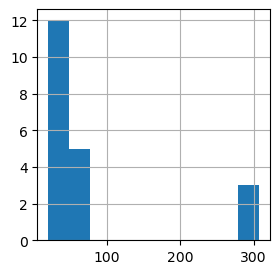

In [157]:
# widać, że to faktycznie ekstremalna wartość, bo 3 osoby mają wiek równy 300
df.fillna(imp_dict)["wiek"].hist(figsize=(3,3))

<Axes: >

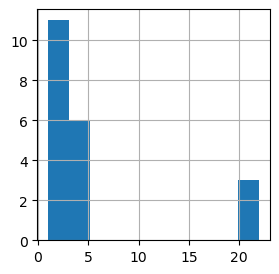

In [158]:
df.fillna(imp_dict)["liczba_pokoi"].hist(figsize=(3,3)) # XD

### End of distribution imputation with `feature_engine`

In [159]:
from feature_engine.imputation import EndTailImputer

In [161]:
# "gausian" by default, "right" tail by default, "fold"=3 by default, czyli mnożymy domyślnie przez 3 (reguła 3 sigm)
imputer = EndTailImputer()
imputer.fit(df)

,imputation_method,'gaussian'
,tail,'right'
,fold,3
,variables,None


In [163]:
imputer.variables_

['wiek',
 'wzrost_cm',
 'dochód_mies',
 'liczba_dzieci',
 'liczba_pokoi',
 'ocena_usługi',
 'czas_spędzony_online_h']

In [164]:
imputer.imputer_dict_

{'wiek': 78.45551686250234,
 'wzrost_cm': 196.53186730874145,
 'dochód_mies': 9740.901327675409,
 'liczba_dzieci': 4.989703290245874,
 'liczba_pokoi': 7.093598834767179,
 'ocena_usługi': 7.176373837962378,
 'czas_spędzony_online_h': 8.141408664499172}

In [165]:
imputer.transform(df)

,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
0,56.000000,170.200000,5849.000000,0.000000,3.000000,NaN,niebieskie,średnie,1.000000,8.141409
1,78.455517,165.700000,3943.000000,2.000000,5.000000,Kraków,zielone,podyplomowe,4.000000,1.400000
2,32.000000,164.700000,9740.901328,0.000000,2.000000,Wrocław,niebieskie,podyplomowe,5.000000,0.700000
3,60.000000,168.800000,4470.000000,0.000000,7.093599,NaN,NaN,podyplomowe,1.000000,0.700000
4,25.000000,172.200000,4308.000000,0.000000,1.000000,Kraków,brązowe,podyplomowe,3.000000,0.100000
5,38.000000,162.300000,5100.000000,4.989703,4.000000,Wrocław,niebieskie,podyplomowe,3.000000,1.900000
6,56.000000,171.400000,4736.000000,0.000000,1.000000,Wrocław,NaN,średnie,1.000000,8.141409
7,36.000000,169.700000,6801.000000,4.989703,4.000000,Warszawa,brązowe,średnie,5.000000,0.100000
8,40.000000,181.300000,6048.000000,0.000000,2.000000,NaN,niebieskie,wyższe,1.000000,0.700000
9,28.000000,169.000000,9740.901328,3.000000,1.000000,Wrocław,niebieskie,podyplomowe,3.000000,4.800000


<Axes: >

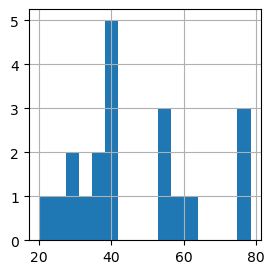

In [168]:
imputer.transform(df)["wiek"].hist(figsize=(3,3), bins=16)

<Axes: >

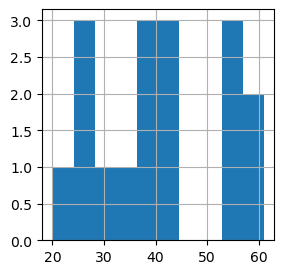

In [169]:
df["wiek"].hist(figsize=(3,3))

# Mean / median per group imputation

### Mean / median per group imputation with `pandas`

In [188]:
płeć = ["kobieta", "mężczyzna"]
df.insert(0, "płeć", np.random.choice(płeć, size=20))
df

,płeć,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
0,kobieta,56.0,170.2,5849.0,0.0,3.0,NaN,niebieskie,średnie,1.0,NaN
1,kobieta,NaN,165.7,3943.0,2.0,5.0,Kraków,zielone,podyplomowe,4.0,1.4
2,mężczyzna,32.0,164.7,NaN,0.0,2.0,Wrocław,niebieskie,podyplomowe,5.0,0.7
3,mężczyzna,60.0,168.8,4470.0,0.0,NaN,NaN,NaN,podyplomowe,1.0,0.7
4,kobieta,25.0,172.2,4308.0,0.0,1.0,Kraków,brązowe,podyplomowe,3.0,0.1
5,mężczyzna,38.0,162.3,5100.0,NaN,4.0,Wrocław,niebieskie,podyplomowe,3.0,1.9
6,kobieta,56.0,171.4,4736.0,0.0,1.0,Wrocław,NaN,średnie,1.0,NaN
7,mężczyzna,36.0,169.7,6801.0,NaN,4.0,Warszawa,brązowe,średnie,5.0,0.1
8,kobieta,40.0,181.3,6048.0,0.0,2.0,NaN,niebieskie,wyższe,1.0,0.7
9,kobieta,28.0,169.0,NaN,3.0,1.0,Wrocław,niebieskie,podyplomowe,3.0,4.8


Chcemy zrobić median imputation depending on the gender ("kobieta", "mężczyzna").

In [189]:
# robimy df z medianami dla wszystkich kolumb numerycznych num_cols
df.groupby("płeć")[num_cols].median()

,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,ocena_usługi,czas_spędzony_online_h
płeć,,,,,,,
kobieta,39.0,169.6,5770.0,0.0,3.0,1.5,1.4
mężczyzna,41.0,166.1,5395.0,2.0,3.5,4.0,0.7


In [190]:
imp_gender_dict = {}
for gender in df["płeć"].unique():
    imp_gender_dict[gender] = df[df["płeć"]==gender][num_cols].median().to_dict()

imp_gender_dict

{'kobieta': {'wiek': 39.0,
  'wzrost_cm': 169.6,
  'dochód_mies': 5770.0,
  'liczba_dzieci': 0.0,
  'liczba_pokoi': 3.0,
  'ocena_usługi': 1.5,
  'czas_spędzony_online_h': 1.4},
 'mężczyzna': {'wiek': 41.0,
  'wzrost_cm': 166.1,
  'dochód_mies': 5395.0,
  'liczba_dzieci': 2.0,
  'liczba_pokoi': 3.5,
  'ocena_usługi': 4.0,
  'czas_spędzony_online_h': 0.7}}

In [203]:
# imputowanie odpowiednimi słownikami

# pierwszy sposób bardzo na około XD
df.iloc[df[df["płeć"]=="kobieta"].index,:] = df.iloc[df[df["płeć"]=="kobieta"].index,:].fillna(imp_gender_dict["kobieta"])

# drugi sposób już normalnie XD
df[df["płeć"]=="mężczyzna"] = df[df["płeć"]=="mężczyzna"].fillna(imp_gender_dict["mężczyzna"])
df

,płeć,wiek,wzrost_cm,dochód_mies,liczba_dzieci,liczba_pokoi,miasto,kolor_oczu,wykształcenie,ocena_usługi,czas_spędzony_online_h
0,kobieta,56.0,170.2,5849.0,0.0,3.0,NaN,niebieskie,średnie,1.0,1.4
1,kobieta,39.0,165.7,3943.0,2.0,5.0,Kraków,zielone,podyplomowe,4.0,1.4
2,mężczyzna,32.0,164.7,5395.0,0.0,2.0,Wrocław,niebieskie,podyplomowe,5.0,0.7
3,mężczyzna,60.0,168.8,4470.0,0.0,3.5,NaN,NaN,podyplomowe,1.0,0.7
4,kobieta,25.0,172.2,4308.0,0.0,1.0,Kraków,brązowe,podyplomowe,3.0,0.1
5,mężczyzna,38.0,162.3,5100.0,2.0,4.0,Wrocław,niebieskie,podyplomowe,3.0,1.9
6,kobieta,56.0,171.4,4736.0,0.0,1.0,Wrocław,NaN,średnie,1.0,1.4
7,mężczyzna,36.0,169.7,6801.0,2.0,4.0,Warszawa,brązowe,średnie,5.0,0.1
8,kobieta,40.0,181.3,6048.0,0.0,2.0,NaN,niebieskie,wyższe,1.0,0.7
9,kobieta,28.0,169.0,5770.0,3.0,1.0,Wrocław,niebieskie,podyplomowe,3.0,4.8
